In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from timebudget import timebudget

from cplAE_MET.utils.load_config import load_config
from cplAE_MET.utils.dataset import load_MET_dataset 
from cplAE_MET.utils.dataclass import met_dataclass

from cplAE_MET.models.subnetworks_T import AE_T


dir_pth = load_config('config.toml')
D = load_MET_dataset(dir_pth['MET_data'])
dat = met_dataclass(D)

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
xt = torch.as_tensor(dat.XT).float().to(device)
valid_xt = ~torch.isnan(xt)
xt = torch.nan_to_num(xt)

In [3]:
model_config = dict(latent_dim=2,
                    T=dict(dropout_p=0.2),
                    E=dict(gnoise_std_frac=0.05,
                           dropout_p=0.2))
ae_t = AE_T(config=model_config)
ae_t.to(device)
optimizer = torch.optim.Adam(ae_t.parameters(), lr=0.001)

valid_t_cells cells 6510
step: 199 loss: 3.57177996635437


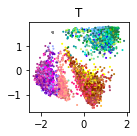

step: 399 loss: 2.956031322479248


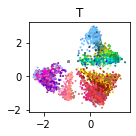

step: 599 loss: 2.7116169929504395


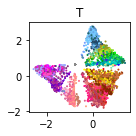

step: 799 loss: 2.5467278957366943


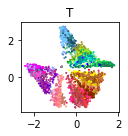

step: 999 loss: 2.4836440086364746


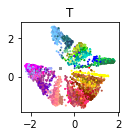

step: 1199 loss: 2.3960437774658203


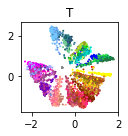

step: 1399 loss: 2.3736860752105713


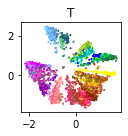

step: 1599 loss: 2.3564164638519287


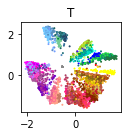

step: 1799 loss: 2.3331267833709717


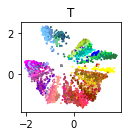

step: 1999 loss: 2.320505142211914


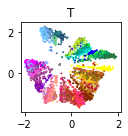

In [4]:
# do this for every batch (if using batching)
valid_t_cells = ~torch.all(~valid_xt.view(valid_xt.shape[0], -1), dim=1)
print(f'valid_t_cells cells {torch.sum(valid_t_cells.int())}')

# Train loop -----------
for step in range(2000):
    optimizer.zero_grad()

    # t arm
    zt = ae_t.enc_xt_to_zt(xt)
    xrt = ae_t.dec_zt_to_xt(zt)

    loss_rec_t = torch.mean(torch.masked_select(torch.square(xt-xrt), valid_xt))
    loss = loss_rec_t

    loss.backward()
    optimizer.step()
    if (step+1) % 200 == 0:
        print(f'step: {step} loss: {loss.to("cpu").detach().numpy()}')
        zt = zt.detach().to('cpu').numpy()
        
        f,ax = plt.subplots(1,1, figsize=(2,2))
        ax.scatter(zt[:,0],zt[:,1],c=dat.cluster_color,s=1)
        ax.set(title='T')
        plt.tight_layout()
        plt.show()